<a href="https://colab.research.google.com/github/NataliaKor/tutorial/blob/main/tutorial-ML-for-GWPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial on Machine Learning for Gravitational Wave Parameter Estimation

### Stephen Green *stephen.green2@nottingham.ac.uk* and Natalia Korsakova *korsakova@apc.in2p3.fr*

---

In this tutorial we will build a simple parameter estimation neural network for galactic binaries. Steps are as follows:

1. **Build a set of training waveforms.** We use the FastGB waveforms package.
2. **Build a posterior model $q(\theta | d)$** using a neural network. We will consider two cases:
    - Gaussian distribution with diagonal (learnable) covariance.
    - Normalizing flow (RealNVP).
3. **Train the model to represent the posterior**, i.e., $q(\theta|d) \to p(\theta|d)$.
4. **Evaluate** on test data.

### Exercises
1. Add inclination in addition to f0 and amplitude
2. Extend the Gaussian distribution to include general covariance
3. Make a PP plot

## Imports

In [1]:
!pip install corner

^C
ERROR: Operation cancelled by user


In [2]:
# pytorch imports
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
from torch import distributions

from sklearn import datasets

In [3]:
import matplotlib.pyplot as plt
import corner
import numpy as np
if torch.cuda.is_available():
   import cupy as cp
else:
   import numpy as cp
   

In [4]:
!git clone https://github.com/NataliaKor/GBGPU.git

fatal: destination path 'GBGPU' already exists and is not an empty directory.


In [4]:
from GBGPU.gbgpu.gbgpu import GBGPU
from GBGPU.gbgpu.noisemodel import AnalyticNoise 

## Training data

We will be performing inference for galactic binaries. The first step is to generate a training set. For simplicity, we sample only in the 2D space consisting of amplitude $A$ and frequency $f_0$, and we take these to have uniform priors over some range. The remaining parameters are held fixed for now.

We generate frequency-domain waveforms using FastGB. We will add noise during training.

**Exercise:** Add more parameters. Start with the inclination [$p(\iota) \propto \sin(\iota)$, $0\le\iota\le2\pi$].

### Waveforms

In [5]:
# Initialise class for waveform generation

gb = GBGPU(use_gpu=False)

In [6]:
num_samples = 100000  # size of the training set

# We choose a very narrow frequency range.
f0_lower = 0.010062
f0_upper = 0.010084

# Amplitude range.
amplitude_lower = 1e-23
amplitude_upper = 1e-21

# Sample frequency
f0 = np.random.uniform(f0_lower, f0_upper, num_samples)

# Sample amplitude
amplitude = np.random.uniform(amplitude_lower, amplitude_upper, num_samples)

In [7]:
iota = cp.arccos(1 - 2 * cp.random.uniform(0, 1, num_samples))

In [8]:
# Fixed parameters

fdot = np.repeat(1.79e-15, num_samples)
lam  = np.repeat(4.36, num_samples)
beta = np.repeat(2.18, num_samples)
# iota = np.repeat(0.67, num_samples)
phi0 = np.repeat(5.48, num_samples)
psi  = np.repeat(0.43, num_samples)

In [9]:
# Waveform settings

Tobs = 31536000.0  # One-year observation
dt = 15.0  # Do we need this to be this short? This gives a Nyqist frequency well over twice f_max.
df = 1./Tobs

# Choose a frequency range that will fit all of the waveforms, i.e., slightly larger than [f0_lower, f0_upper].
f_min = 0.010059
f_max = 0.0100861

# Define the frequency grid.
num_bins = int((f_max - f_min) / df) + 1
sample_frequencies = np.linspace(f_min, f_max, num=num_bins)

### Noise

In [10]:
# Noise PSD

noise = AnalyticNoise(sample_frequencies)
psdA, psdE = noise.psd(option="A"), noise.psd(option="E")

asdA = np.sqrt(psdA).astype(np.float32)
asdE = np.sqrt(psdE).astype(np.float32)

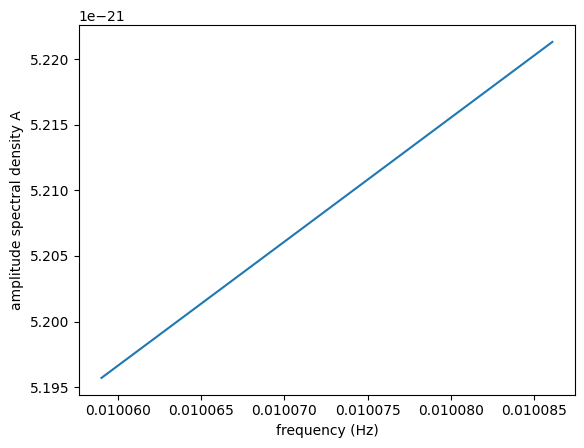

In [11]:
plt.plot(sample_frequencies, asdA)
plt.xlabel('frequency (Hz)')
plt.ylabel('amplitude spectral density A')
plt.show()

In [12]:
# Generate training waveforms
N_points = 128

params = np.array([amplitude, f0, fdot, 0.0, -phi0, iota, psi, lam, beta])
gb.run_wave(*params, N = N_points, dt = dt, T = Tobs, oversample = 1)#oversample=2)

k_min = round(f_min/df)
k_max = round(f_max/df)
num = len(sample_frequencies)
    
if torch.cuda.is_available():
    i_start = (gb.start_inds.get() - k_min).astype(np.int32)
    i_end = (gb.start_inds.get() - k_min + gb.N).astype(np.int32)
else:
    i_start = gb.start_inds - k_min
    i_end = gb.start_inds - k_min + gb.N

# A_out = cp.zeros((num_samples, num), dtype=cp.complex128)
# E_out = cp.zeros((num_samples, num), dtype=cp.complex128)

Awf = cp.empty((num_samples, num), dtype=cp.complex64)
Ewf = cp.empty((num_samples, num), dtype=cp.complex64)

for i in range(num_samples):
    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.A[i]
    x *= cp.sqrt(4 * df) / asdA
    Awf[i] = x
    
    x = cp.zeros(num, dtype=cp.complex128)
    x[i_start[i]:i_end[i]] = gb.E[i]
    x *= cp.sqrt(4 * df) / asdE
    Awf[i] = x

/var/folders/19/tjgs38zs3h5bbw8vr10kscdc0000gp/T/ipykernel_74817/3228207895.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  params = np.array([amplitude, f0, fdot, 0.0, -phi0, iota, psi, lam, beta])


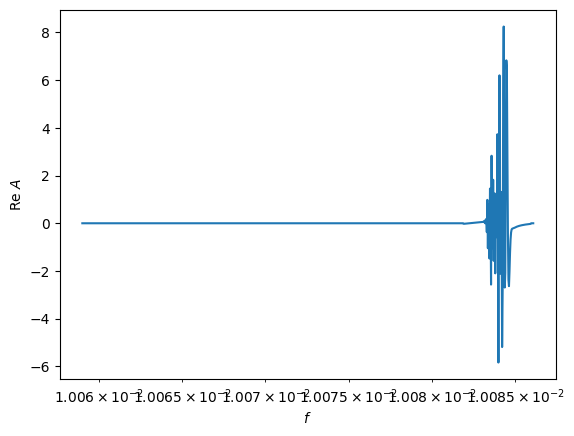

In [19]:
# Sample waveform
if torch.cuda.is_available():
  Awf_plot = Awf[0].real.get()
else:
  Awf_plot = Awf[0].real

plt.plot(sample_frequencies, Awf_plot)
plt.xscale('log')
plt.xlabel('$f$')
plt.ylabel('Re $A$')

# plt.xlim((1.006e-2, 1.0065e-2))

plt.show()

### Package into a pytorch Dataset

In [25]:
# Combine parameters into array

parameters = np.stack((f0, amplitude, iota), axis=1).astype(np.float32)

In [26]:
# For best training, parameters should be standardized (zero mean, unit variance across the training set)

parameters_mean = np.mean(parameters, axis=0)
parameters_std = np.std(parameters, axis=0)

parameters_standardized = (parameters - parameters_mean) / parameters_std

In [27]:
waveforms = np.hstack((Awf.real, Awf.imag)).astype(np.float32)

In [28]:
class WaveformDataset(Dataset):
    
    def __init__(self, parameters, waveforms, norm_for_all=1):
        self.parameters = parameters
        self.waveforms = waveforms
        self.norm_for_all = norm_for_all

    def __len__(self):
        return len(self.parameters)

    def __getitem__(self, idx):
        params = self.parameters[idx]
        signal = self.waveforms[idx]
        
        # Add unit normal noise to the signal
        noise = cp.random.normal(size = signal.shape).astype(cp.float32)
        data = ((signal + noise)/self.norm_for_all).astype(cp.float32)
        
        return torch.tensor(data), torch.tensor(params)

In [29]:
waveform_dataset = WaveformDataset(parameters_standardized, waveforms)

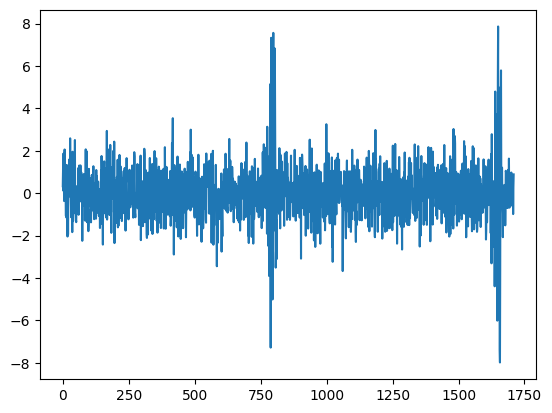

In [31]:
# We can sample from the WaveformDataset. This gives us pairs of data and parameters, different noise realizations each time.

x, y = waveform_dataset[0]
plt.plot(x)

## Posterior Model

In [32]:
# Neural networks are constructed by subclassing nn.Module
#
# This has to implement an __init__() and forward() method

class NeuralNetwork(nn.Module):
    
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.ReLU()):
        super(NeuralNetwork, self).__init__()
        
        # Hidden layers
        hidden_net_list = []
        hidden_net_list.append(
            nn.Linear(input_dim, hidden_dims[0]))
        for i in range(1, len(hidden_dims)):
            hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
        self.hidden_net_list = nn.ModuleList(hidden_net_list)
        
        # Output layers
        self.output_mean = nn.Linear(hidden_dims[-1], output_dim)
        self.output_log_sigma = nn.Linear(hidden_dims[-1], output_dim)
        
        # Activation function
        self.activation = activation
        
    def forward(self, x):
        """Pass x through all the layers of the network and return the Gaussian distribution"""
        
        h = x
        for layer in self.hidden_net_list:
            h = self.activation(layer(h))

        # Output layer defines a Gaussian
        mean = self.output_mean(h)
        log_sigma = self.output_log_sigma(h)
        sigma = torch.exp(log_sigma)
        
        # Create the Gaussian distribution
        dist = torch.distributions.MultivariateNormal(loc=mean, scale_tril=torch.diag_embed(sigma))
        
        return dist

In [33]:
input_dim = waveforms.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

model = NeuralNetwork(input_dim, hidden_dims, output_dim)

In [34]:
print(model)

NeuralNetwork(
  (hidden_net_list): ModuleList(
    (0): Linear(in_features=1710, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_mean): Linear(in_features=32, out_features=3, bias=True)
  (output_log_sigma): Linear(in_features=32, out_features=3, bias=True)
  (activation): ReLU()
)


## Training

In [35]:
# Split the dataset into training and test sets

train_fraction = 0.8
num_train = int(round(train_fraction * num_samples))
num_test = num_samples - num_train
train_dataset, test_dataset = random_split(waveform_dataset, [num_train, num_test])

# The DataLoader is used in training

train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [36]:
# The DataLoaders iterate over samples, returning torch tensors containing a batch of data

train_features, train_labels = next(iter(train_dataloader))

In [37]:
# We use the Adam optimizer.

#optimizer = torch.optim.Adam(model.parameters())
optimizer = torch.optim.Adam([p for p in model.parameters() if p.requires_grad==True], lr=1e-3)

In [38]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss
        dist = model(X)        
        loss = - dist.log_prob(y)
        
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            dist = model(X)
            loss = - dist.log_prob(y)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [39]:
epochs = 20
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, model, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, model)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: 4.413906  [    0/80000 samples]
Loss: 3.506677  [12800/80000 samples]
Loss: 3.370792  [25600/80000 samples]
Loss: 3.100911  [38400/80000 samples]
Loss: 3.002173  [51200/80000 samples]
Loss: 2.756994  [64000/80000 samples]
Loss: 2.230807  [76800/80000 samples]
Average loss: 3.0947
Test loss: 2.178141 

Epoch 2
-------------------------------
Loss: 2.059527  [    0/80000 samples]
Loss: 2.139073  [12800/80000 samples]
Loss: 1.749661  [25600/80000 samples]
Loss: 1.592486  [38400/80000 samples]
Loss: 1.628785  [51200/80000 samples]
Loss: 1.757884  [64000/80000 samples]
Loss: 1.314302  [76800/80000 samples]
Average loss: 1.5904
Test loss: 1.190905 

Epoch 3
-------------------------------
Loss: 0.978662  [    0/80000 samples]
Loss: 0.866097  [12800/80000 samples]
Loss: 0.600691  [25600/80000 samples]
Loss: 0.520445  [38400/80000 samples]
Loss: 0.637638  [51200/80000 samples]
Loss: 0.577805  [64000/80000 samples]
Loss: 0.400907  [76800/80000 sampl

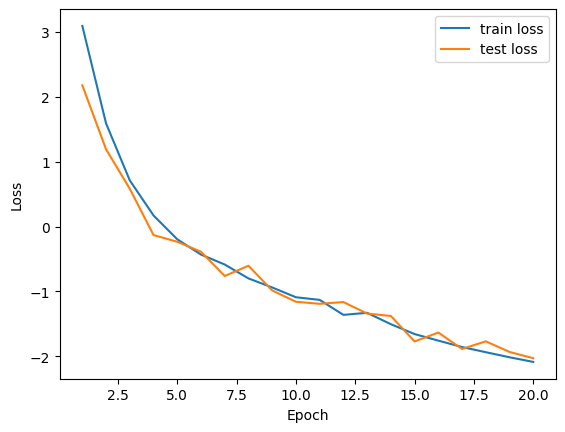

In [40]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluation

### Posterior plots

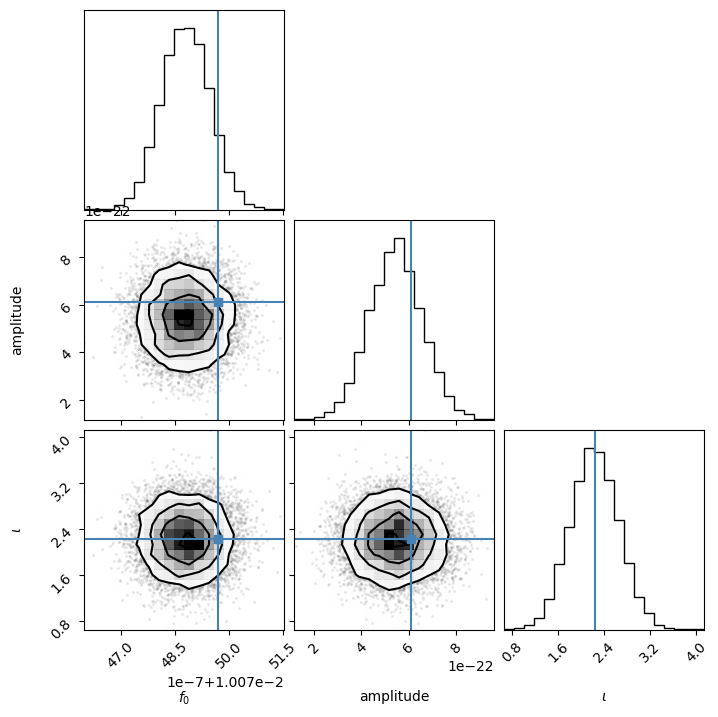

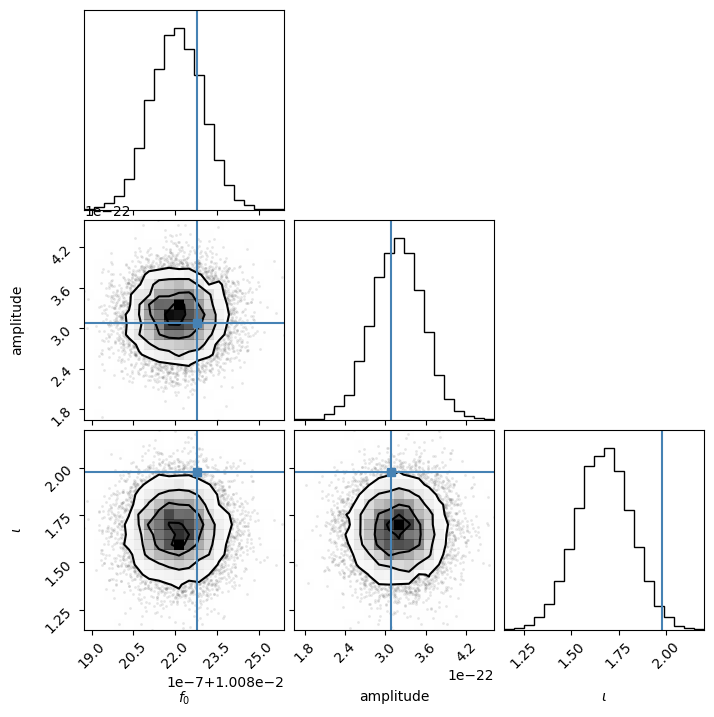

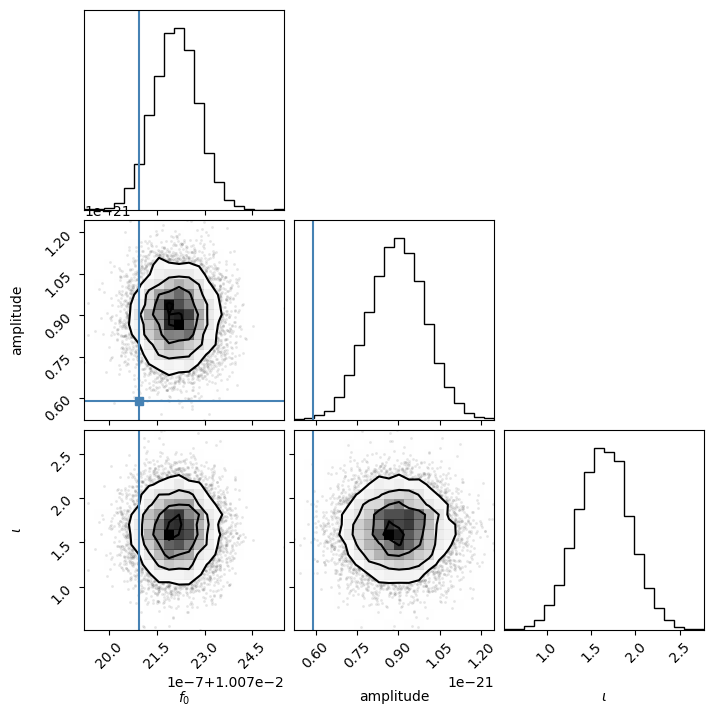

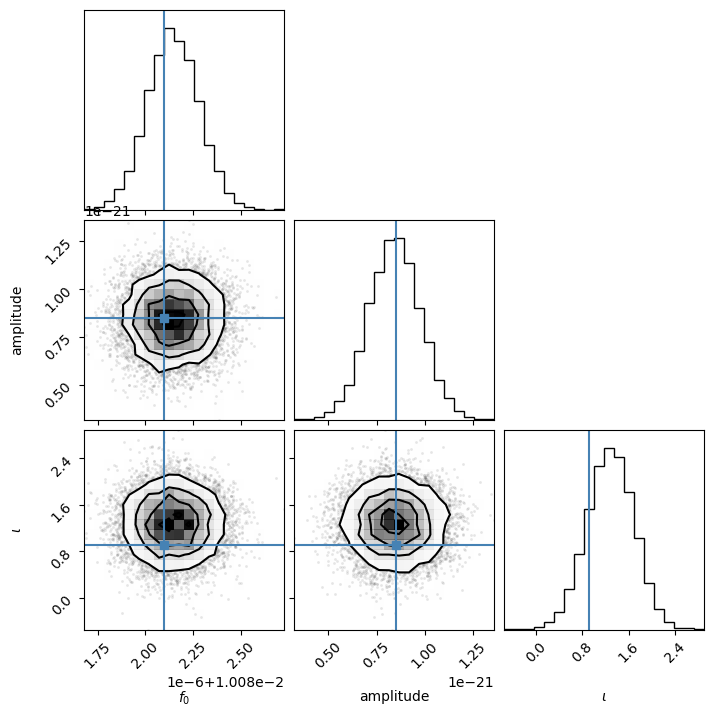

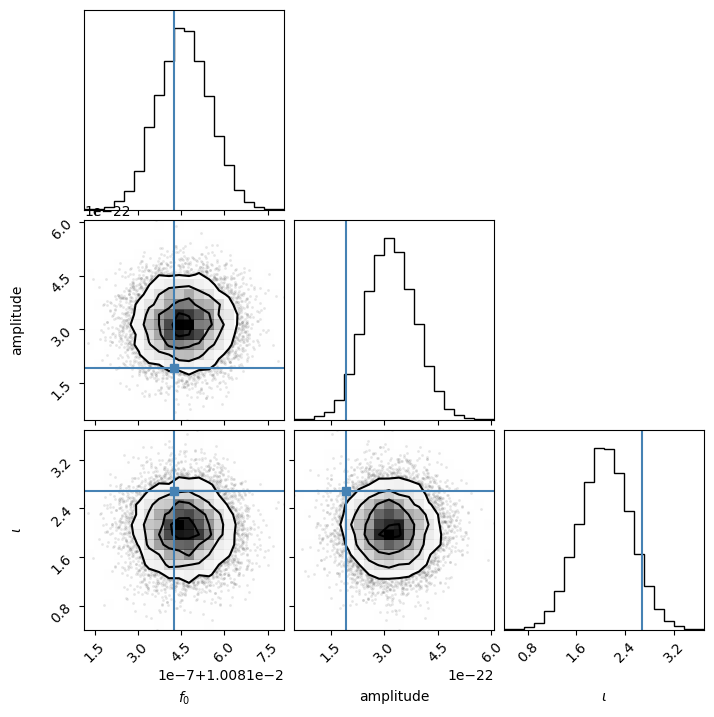

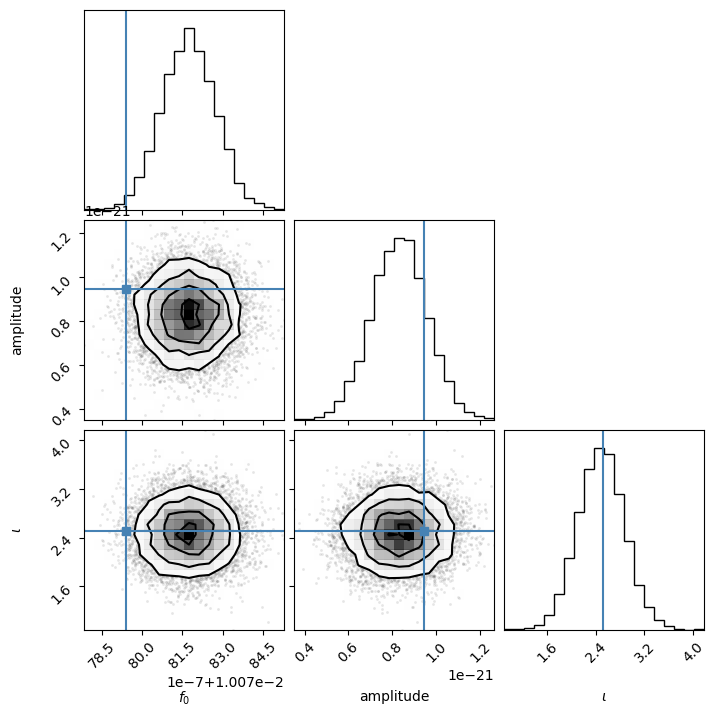

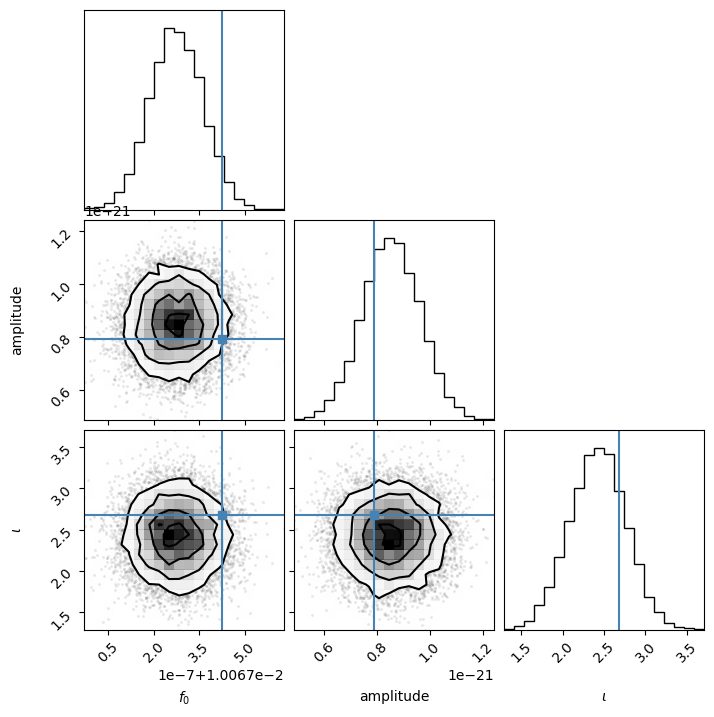

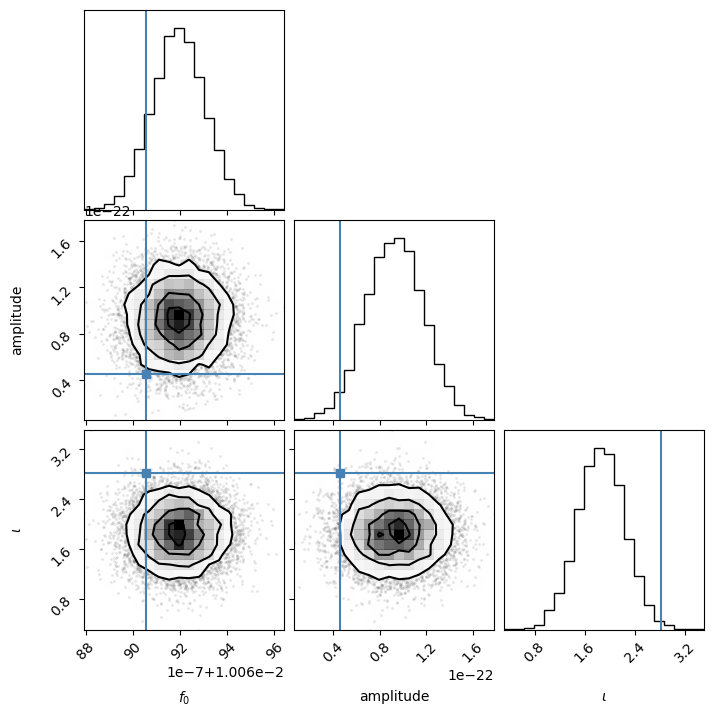

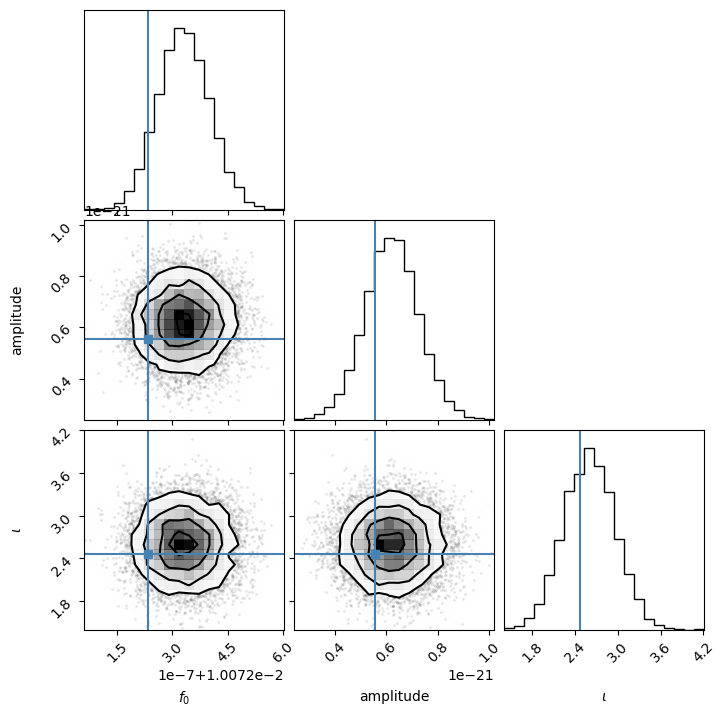

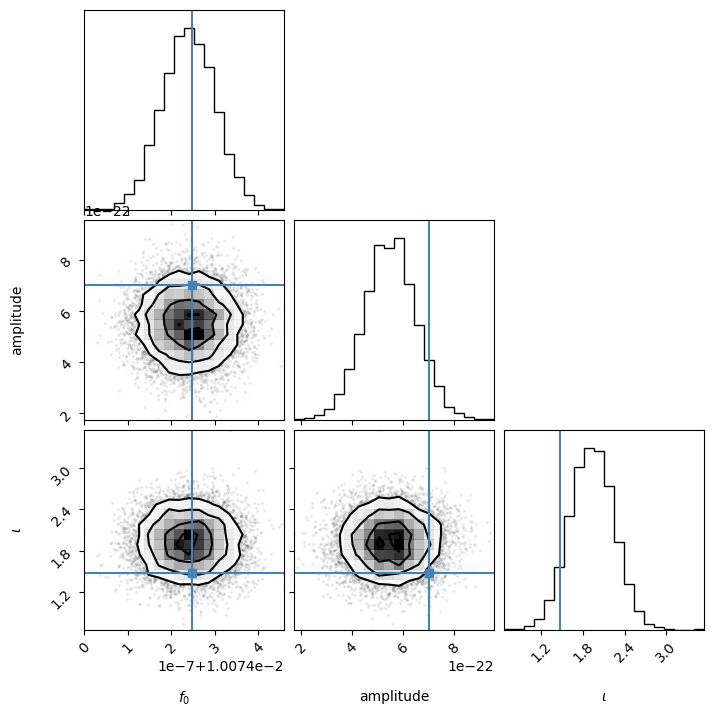

In [42]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Predict a posterior
    dist = model(test_x)

    # Sample the posterior
    pred_samples = dist.sample((10000,)).numpy()

    # Undo the standardization
    
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f_0$', 'amplitude', '$\iota$'])
    plt.show()


# @Normalising flow 

We will implement the RealNVP 

https://arxiv.org/abs/1605.08803

It is based on the simple affine transformation, where part of the dimensions are scaled and shifted.

Let's assume that we separate the dimensions into two parts:
$x_{1:d}$ and $x_{d+1:D}$  

Half of the dimensions are kept unchanged:

$y_{1:d} = x_{1:d}$

Other half is transformed with affine transform. Lets define $t$ is a 'shift' function and $s$ is a 'scale' functions. We will parameterise them with neural networks. We apply this transformations to the first part of data:
$s(x_{1:d})$ and $t(x_{1:d})$.

Then we combine it with the data from the second half of dimensions and get:
$y_{d+1:D} = x_{d+1:D} \odot \exp(s(x_{1:d})) + t(x_{1:d})$.

-----------------------------------------------------------------------------


To devide dimensions we use a mask:

In [61]:
masks = torch.from_numpy(np.array([[0, 1], [1, 0]] * 3).astype(np.float32))
masks

tensor([[0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.]])

Trabsformations $s$ and $t$ :

In [62]:
# Define functions s and t as simple fully connected networks:

def t_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    
    return nn.Sequential(*hidden_net_list)
 
def s_func(input_dim, hidden_dims, output_dim):
        
    hidden_net_list = []
    hidden_net_list.append(nn.Linear(input_dim, hidden_dims[0]))
    for i in range(1, len(hidden_dims)):
      hidden_net_list.append(nn.Linear(hidden_dims[i-1], hidden_dims[i]))
      hidden_net_list.append(nn.ReLU())
    hidden_net_list.append(nn.Linear(hidden_dims[i], output_dim))
    hidden_net_list.append(nn.Tanh())

    return nn.Sequential(*hidden_net_list) 
     


In [63]:
input_dim = waveforms.shape[-1] + parameters.shape[-1]
output_dim = parameters.shape[-1]
hidden_dims = [512, 256, 128, 64, 32]

Base distribution is chosen to be Gaussian Multivariate Distribution.



In [64]:

prior = distributions.MultivariateNormal(torch.zeros(2), torch.eye(2))

Implementation of the flow:

In [68]:
masks.shape

torch.Size([6, 2])

In [65]:
class RealNVP_wf(nn.Module):
    def __init__(self, s_func, t_func, mask, prior):
        super(RealNVP_wf, self).__init__()
        
        self.prior = prior

        self.register_buffer('mask', mask)
        self.t = torch.nn.ModuleList([t_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([s_func(input_dim, hidden_dims, output_dim) for _ in range(len(masks))])
        
    def g(self, z, w):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            x_wf = torch.cat([x_, w],dim=1)
            s = self.s[i](x_wf)*(1 - self.mask[i])
            t = self.t[i](x_wf)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x, w):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            z_wf = torch.cat([z_, w],dim=1)
            s = self.s[i](z_wf) * (1-self.mask[i])
            t = self.t[i](z_wf) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    
    def log_prob(self, x, w):
        z, logp = self.f(x, w)
        return self.prior.log_prob(z) + logp
        


In [66]:
flow_wf = RealNVP_wf(s_func, t_func, masks, prior)

In [69]:
# Training and test loops

def train_loop(dataloader, model, optimizer):
 
    size = len(dataloader.dataset)
    train_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        # Compute negative log probability loss

        loss = - model.log_prob(y, X)
    
        train_loss += loss.detach().sum()
        loss = loss.mean()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 50 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"Loss: {loss:>7f}  [{current:>5d}/{size:>5d} samples]")
            
    average_loss = train_loss.item() / size
    print('Average loss: {:.4f}'.format(average_loss))
    return average_loss
            
              
def test_loop(dataloader, model):
    size = len(dataloader.dataset)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:

            loss = - model.log_prob(y, X)
            test_loss += loss.sum()

    test_loss /= size
    print(f"Test loss: {test_loss:>8f} \n")
    return test_loss

In [70]:
optimizer = torch.optim.Adam([p for p in flow_wf.parameters() if p.requires_grad==True], lr=1e-3)

In [72]:
epochs = 5
train_history = []
test_history = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train_loop(train_dataloader, flow_wf, optimizer)
    train_history.append(loss)
    loss = test_loop(test_dataloader, flow_wf)
    test_history.append(loss)
print("Done!")

Epoch 1
-------------------------------
Loss: -2.266464  [    0/80000 samples]
Loss: -2.085977  [12800/80000 samples]
Loss: -2.358795  [25600/80000 samples]
Loss: -2.485884  [38400/80000 samples]
Loss: -2.227473  [51200/80000 samples]
Loss: -2.455097  [64000/80000 samples]
Loss: -2.387244  [76800/80000 samples]
Average loss: -2.3085
Test loss: -2.359150 

Epoch 2
-------------------------------
Loss: -2.332361  [    0/80000 samples]
Loss: -1.111175  [12800/80000 samples]
Loss: -1.647470  [25600/80000 samples]
Loss: -2.062925  [38400/80000 samples]
Loss: -2.523294  [51200/80000 samples]
Loss: -2.374951  [64000/80000 samples]
Loss: -2.513126  [76800/80000 samples]
Average loss: -2.1933
Test loss: -2.498019 

Epoch 3
-------------------------------
Loss: -2.456268  [    0/80000 samples]
Loss: -2.266043  [12800/80000 samples]
Loss: -2.511403  [25600/80000 samples]
Loss: -2.492866  [38400/80000 samples]
Loss: -2.264236  [51200/80000 samples]
Loss: -2.564947  [64000/80000 samples]
Loss: -2.6

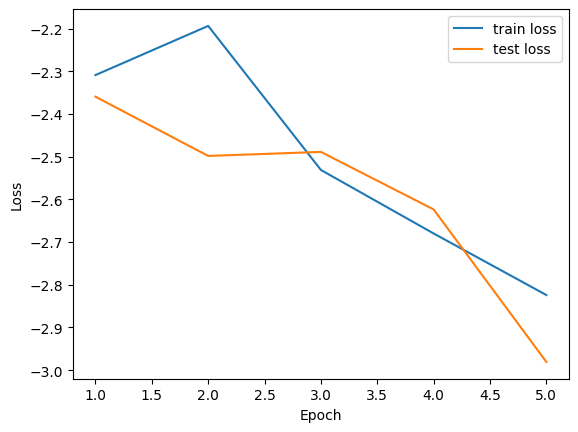

In [73]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

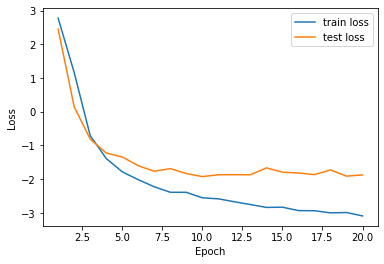

In [86]:
epochs = np.arange(1, len(train_history) + 1)
plt.plot(epochs, train_history, label = 'train loss')
plt.plot(epochs, test_history, label = 'test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

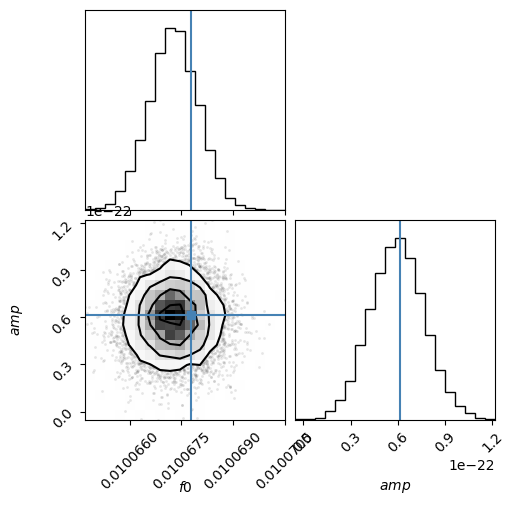

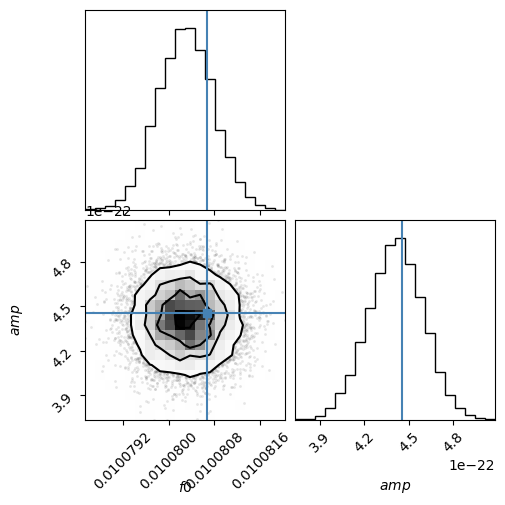

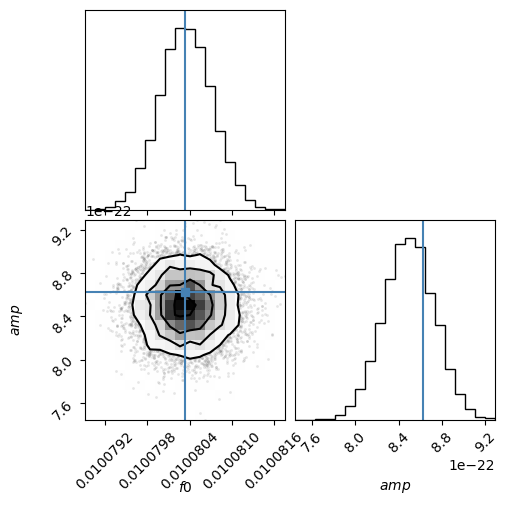

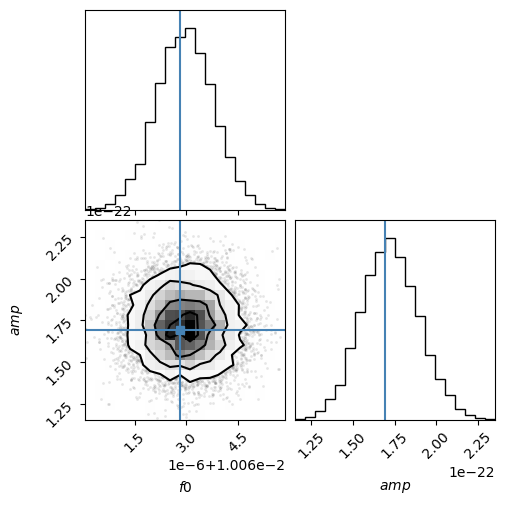

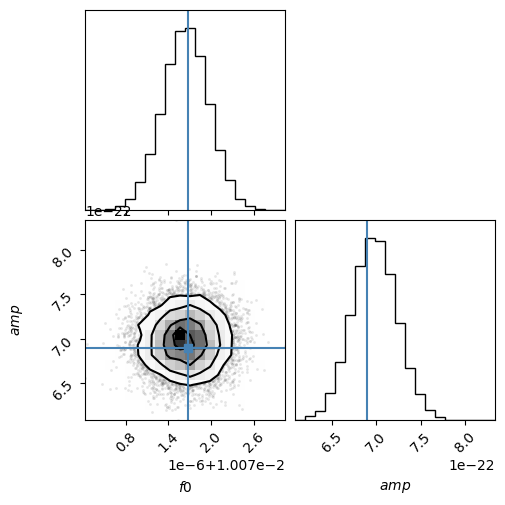

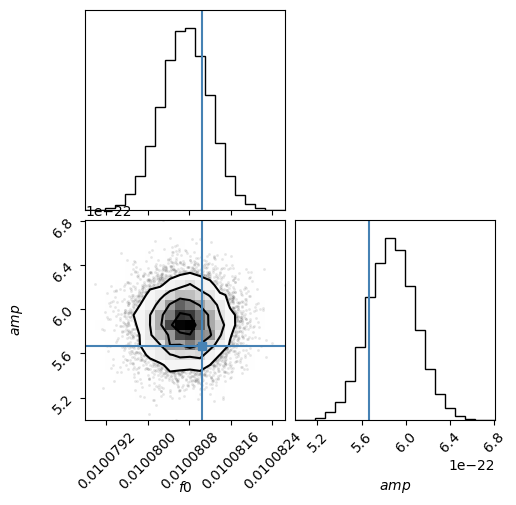

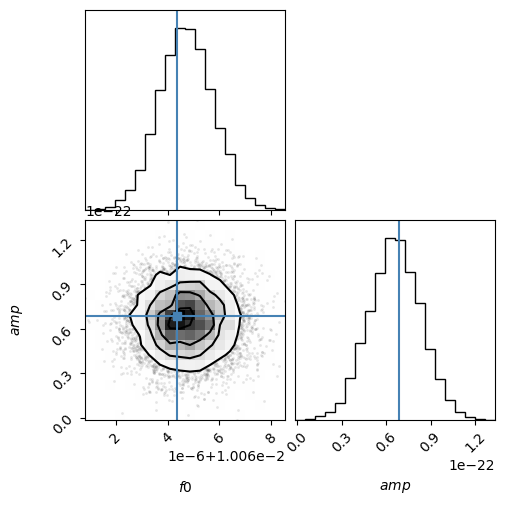

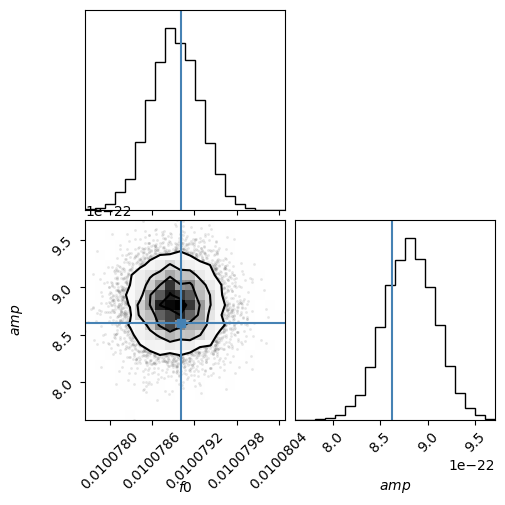

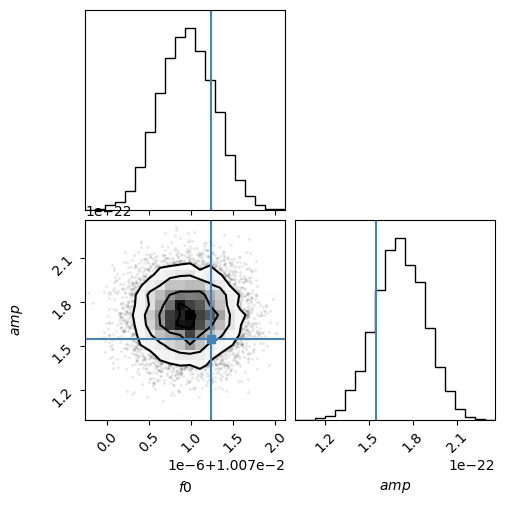

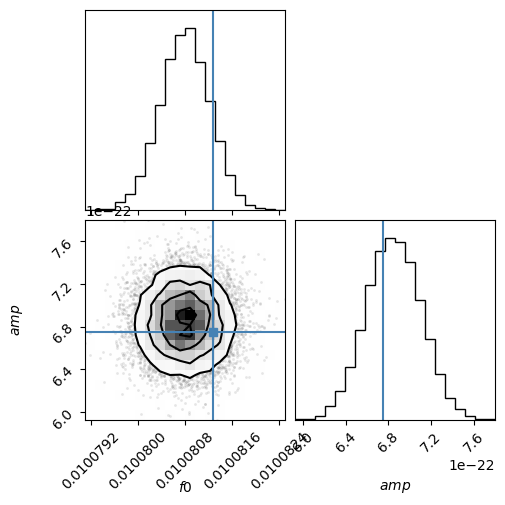

In [74]:
num_posteriors = 10
num_samples = 10000

for n in range(num_posteriors):
    test_x, test_y = test_dataset[n]

    # Repeat same wf for a number of samples
    wf = torch.from_numpy(np.tile(test_x, (num_samples, 1))).type(torch.FloatTensor)

    # Sample from base distribution
    z = prior.sample((num_samples,1)).view(num_samples,-1)

    # Predict a posterior
    pred_samples = flow_wf.g(z, wf).detach().numpy() 

    # Undo the standardization
    pred_samples = parameters_std * pred_samples + parameters_mean
    truth = parameters_std * test_y.numpy() + parameters_mean

    # Plot
    corner.corner(pred_samples, truths=truth, labels=['$f0$', '$amp$'])
    plt.show()